<a href="https://colab.research.google.com/github/ngupta23/medium_articles/blob/main/time_series/pycaret/pycaret_ts_arima_trend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Previous Article(s) in this Series

- [A Practical Guide to ARIMA Models using PyCaret — Part 1](https://medium.com/p/692e10ca02f2)

## Install & Import Library




In [1]:
try:
  import pycaret
except:
  !pip install pycaret-ts-alpha

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from pycaret.datasets import get_data
from pycaret.internal.pycaret_experiment import TimeSeriesExperiment
from sklearn.linear_model import LinearRegression

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


## Get Data and Setup PyCaret Experiment

In [3]:
#### Get data from data playground ----
y = get_data("1", folder="time_series/white_noise")

,x
0,175.379633
1,176.042116
2,175.089078
3,176.158029
4,175.345415


In [4]:
exp = TimeSeriesExperiment()
exp.setup(data=y, seasonal_period=1, fh=30, session_id=42)

,Description,Value
0,session_id,42
1,Original Data,"(340, 1)"
2,Missing Values,False
3,Transformed Train Set,"(310,)"
4,Transformed Test Set,"(30,)"
5,Fold Generator,ExpandingWindowSplitter
6,Fold Number,3
7,Enforce Prediction Interval,False
8,Seasonal Period Tested,1
9,Seasonality Detected,False


## EDA

In [5]:
exp.plot_model()

In [6]:
exp.plot_model(plot="acf")
exp.plot_model(plot="pacf")

## Helper functions using PyCaret's Time Series Module

In [7]:
def summarize_model(model):
  """
  Provides statistical summary for some statistical models
  """
  # Statistical Summary Table
  try:
    print(model.summary())
  except:
    print("Summary does not exist for this model.")

In [8]:
def get_residual_properties(model, ddof: int=0):
  """
  Plots and displays variance of residuals
  """
  #### Residuals ----
  try:
    plot_data = exp.plot_model(model, plot="residuals", return_data=True)
    resid = plot_data['data']
    resid_sigma2 = (resid**2).sum()/(len(resid))
    print(f"Residual Sigma 2: {resid_sigma2}")
  except:
    print("Residuals can not be extracted for this model.")

In [9]:
def plot_predictions(model):
  """
  Plots out-of-sample and in-sample predictions
  """
  # Out-of-Sample Forecast
  exp.plot_model(model)
  
  # In-Sample Forecast
  exp.plot_model(model, plot="insample")

## Train & Test Data Properties

In [10]:
# Get Train Data Properties
y_train = exp.get_config("y_train")
print(f"Train Start Index: {y_train.index.min()}\nTrain End Index: {y_train.index.max()}")

# Get Test Data Properties
y_test = exp.get_config("y_test")
print(f"Test Start Index: {y_test.index.min()}\nTest End Index: {y_test.index.max()}")

Train Start Index: 0
Train End Index: 309
Test Start Index: 310
Test End Index: 339


## ARIMA Model with Constant (Intercept) and/or Trend (Slope)

### Theoretical Calculations

#### Model with Intercept only (trend = "c")

- This is the same as the model that we covered in the previous article.
- The best estimate of the constant is the mean of the data used to train the model.
- This applies to the in-sample as well as out-of-sample data

In [11]:
train_data = pd.DataFrame({"y":y_train})
train_data['preds'] = y_train.mean()
train_data['split'] = "Train"

test_data = pd.DataFrame({'y': y_test})
test_data['preds'] = y_train.mean()
test_data['split'] = "Test"

data = pd.concat([train_data, test_data])
data['residuals'] = data['y'] - data['preds']
data.reset_index(inplace=True)

In [12]:
y_train_mean = data.query("split=='Train'")['y'].mean()
resid = data.query("split=='Train'")['residuals']
resid_sigma2 = (resid**2).sum()/len(resid)

print(f"Mean of Training Data: {y_train_mean}")
print(f"Residuals Sigma2: {resid_sigma2}")

Mean of Training Data: 176.01810663414085
Residuals Sigma2: 0.9769567915901368


[Text(0.5, 1.0, 'Theoretical Predictions')]

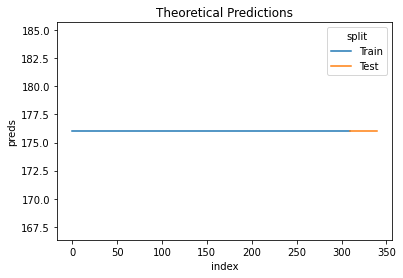

In [13]:
sns.lineplot(data=data, x="index", y="preds", hue="split").set(title="Theoretical Predictions")

But what about the confidence intervals? 95% Prediction Intervals Multiplier = 1.96

CHANGE: Confidence interval = Mean +/- 1.96 * Std of Residuals

In [14]:
import scipy.stats as st
alpha = 0.05

# 2 sided multiplier
multiplier = st.norm.ppf(1-alpha/2)

lower_interval = np.round(y_train_mean - multiplier * resid_sigma2**0.5, 2)
upper_interval = np.round(y_train_mean + multiplier * resid_sigma2**0.5, 2)
print(f"Prediction Interval: {lower_interval} - {upper_interval}")

Prediction Interval: 174.08 - 177.96


#### Model with Trend Only (trend = "t")

- This is like fitting a linear regression model to the data without an intercept.

In [15]:
X_train = np.arange(len(y_train)).reshape(-1, 1)
reg = LinearRegression(fit_intercept=False).fit(X_train, y_train)
print(f"Expected Intercept: {reg.intercept_}")
print(f"Expected Slope: {reg.coef_}")

Expected Intercept: 0.0
Expected Slope: [0.85317393]


#### Model with Intercept and Trend (trend = "ct")

- This is like fitting a linear regression model to the data with an intercept and slope.

In [16]:
X_train = np.arange(len(y_train)).reshape(-1, 1)
reg = LinearRegression(fit_intercept=True).fit(X_train, y_train)
print(f"Expected Intercept: {reg.intercept_}")
print(f"Expected Slope: {reg.coef_}")

Expected Intercept: 175.95815015173943
Expected Slope: [0.00038807]


### Now let's build this model & compare to Theory

## Inclusion of Constants

https://robjhyndman.com/hyndsight/arimaconstants/

Python ARIMA Parameters: https://github.com/alan-turing-institute/sktime/blob/main/sktime/forecasting/arima.py

#### Model with Intercept only (trend = "c")

In [17]:
model2a = exp.create_model("arima", order=(0, 0, 0), seasonal_order=(0, 0, 0, 0), trend="c")

,cutoff,MAE,RMSE,MAPE,SMAPE,R2
0,219.0,0.8275,1.0069,0.0047,0.0047,-0.0007
1,249.0,0.7442,0.9785,0.0042,0.0042,-0.0084
2,279.0,0.8170,0.9894,0.0046,0.0046,-0.0090
Mean,NaN,0.7962,0.9916,0.0045,0.0045,-0.0060
SD,NaN,0.0371,0.0117,0.0002,0.0002,0.0038


In [18]:
summarize_model(model2a)
get_residual_properties(model2a)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  310
Model:                        SARIMAX   Log Likelihood                -436.257
Date:                Fri, 19 Nov 2021   AIC                            876.515
Time:                        21:01:54   BIC                            883.988
Sample:                             0   HQIC                           879.502
                                - 310                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    176.0181      0.056   3134.299      0.000     175.908     176.128
sigma2         0.9770      0.080     12.235      0.000       0.820       1.133
Ljung-Box (L1) (Q):                   0.99   Jarque-

Residual Sigma 2: 0.9769567915901366


In [19]:
plot_predictions(model2a)

The model output matches with our theoretical calculations

#### Model with Trend Only (trend = "t")

In [20]:
model2b = exp.create_model("arima", order=(0, 0, 0), seasonal_order=(0, 0, 0, 0), trend="t")

,cutoff,MAE,RMSE,MAPE,SMAPE,R2
0,219.0,106.0909,106.6141,0.6027,0.4623,-11217.3796
1,249.0,104.0269,104.4415,0.5914,0.4558,-11486.2764
2,279.0,102.1088,102.4403,0.5799,0.4490,-10814.5274
Mean,NaN,104.0755,104.4986,0.5913,0.4557,-11172.7278
SD,NaN,1.6260,1.7044,0.0093,0.0054,276.0519


In [21]:
summarize_model(model2b)
get_residual_properties(model2b)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  310
Model:                        SARIMAX   Log Likelihood               -1828.521
Date:                Fri, 19 Nov 2021   AIC                           3661.043
Time:                        21:01:55   BIC                           3668.516
Sample:                             0   HQIC                          3664.030
                                - 310                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.8532      0.046     18.598      0.000       0.763       0.943
sigma2      7777.8494    832.509      9.343      0.000    6146.162    9409.537
Ljung-Box (L1) (Q):                 306.90   Jarque-

Residual Sigma 2: 7777.844046278534


In [22]:
plot_predictions(model2b)

The model output matches with our theoretical calculations

#### Model with Intercept and Trend (trend = "ct")

In [23]:
model2c = exp.create_model("arima", order=(0, 0, 0), seasonal_order=(0, 0, 0, 0), trend="ct")

,cutoff,MAE,RMSE,MAPE,SMAPE,R2
0,219.0,0.8288,1.0117,0.0047,0.0047,-0.0102
1,249.0,0.7653,0.9930,0.0044,0.0044,-0.0385
2,279.0,0.8186,0.9861,0.0046,0.0046,-0.0021
Mean,NaN,0.8042,0.9969,0.0046,0.0046,-0.0169
SD,NaN,0.0279,0.0108,0.0002,0.0002,0.0156


In [24]:
summarize_model(model2c)
get_residual_properties(model2c)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  310
Model:                        SARIMAX   Log Likelihood                -436.066
Date:                Fri, 19 Nov 2021   AIC                            878.132
Time:                        21:01:57   BIC                            889.342
Sample:                             0   HQIC                           882.614
                                - 310                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    175.9578      0.117   1504.136      0.000     175.728     176.187
drift          0.0004      0.001      0.587      0.557      -0.001       0.002
sigma2         0.9758      0.080     12.169      0.0

Residual Sigma 2: 0.9757523744574852


In [25]:
plot_predictions(model2c)

The model output matches with our theoretical calculations

## Conclusion

Hopefully this exercise has given us a good understanding of the `trend` component of the ARIMA model. In the next set of articles, we will cover the `order` and `seasonal_order` terms in detail.